In [1]:
%config IPCompleter.use_jedi = False
import pandas as pd
import warnings 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from pathlib import Path

In [2]:
proj_path = str(Path().resolve().parent)

In [3]:
FONT_NAME = 'Arial'
FONT_SIZE = 15
import matplotlib as mpl
mpl.rc('font',family='Arial')

In [4]:
file_2d = proj_path + "/results/density2D_64_128.csv" 
file_ts = proj_path + "/results/densityTS_64_128.csv"
file_large = proj_path + "/results/large2D_64_128.csv"
file_largeTS = proj_path + "/results/largeTS_64_128.csv"
file_batchTS = proj_path + "/results/batchTS_64_128.csv"
file_scalabilityTS = proj_path + "/results/scalabilityTS_64_128.csv"

In [6]:
df_2d_column_names = ['FF', 'FFD-Avg', 'FFD-Max',
       'FFD-AvgExpo', 'FFD-Surrogate', 'FFD-ExtendedSum', 'BFD-Avg', 'BFD-Max',
       'BFD-AvgExpo', 'BFD-Surrogate', 'BFD-ExtendedSum', 'BCD-L2Norm', 'BCD-DotProduct',
       'FFD-Degree', 'NodeCount', 'BCD-Fitness']

df_2d_large_column_names = ['FF', 'FFD-Avg', 'FFD-Max',
       'FFD-AvgExpo', 'FFD-Surrogate', 'FFD-ExtendedSum', 'BFD-Avg', 'BFD-Max',
       'BFD-AvgExpo', 'BFD-Surrogate', 'BFD-ExtendedSum', 'BCD-DotProduct',
       'FFD-Degree', 'BCD-Fitness']

df_ts_column_names = ['FF', 'FFD-Avg', 'FFD-Max',
       'FFD-AvgExpo', 'FFD-Surrogate', 'FFD-ExtendedSum', 'BFD-Avg', 'BFD-Max',
       'BFD-AvgExpo', 'BFD-Surrogate', 'BFD-ExtendedSum']

df_ts_large_column_names = ['FF', 'FFD-Avg', 'BFD-Avg', 'FFD-Degree']


df_scalab_column_names = ['FF', 'FFD-Avg', 'BFD-Avg', 'FFD-Degree']

df_batch_column_names = ['FF', 'FFD-Avg', 'BFD-Avg', 'BCD-DotProduct',
                         'FFD-Degree', 'BCD-Fitness']

classes = ['arbitrary', 'normal', 'threshold']

rename_dict = {
    "BCD-L2Norm": "NCD-L2Norm",
    "BCD-DotProduct": "NCD-DotProduct",
    "FFD-Degree": "Medea-TP",
    "NodeCount": "Medea-NC",
    "BCD-Fitness": "LRASched-Fitness"
}

In [7]:
## sub_df = any one in df_2d, df_ts, df_large
def get_exp_results(sub_df, alg_column_names):
    sub_df['class'] = sub_df['instance_name'].apply(lambda x: x.split('_')[0])
    #sub_df['density'] = sub_df['instance_name'].apply(lambda x: x.split('_')[1])
    sub_df['idx'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[2]))
    sub_df['density'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[1][1:]))
    
    for i in alg_column_names:
        sub_df[i + '_eps'] = round(sub_df[i]/sub_df['LB'] - 1, 3)
        sub_df[i + '_time'] = sub_df[i + '_time'].apply(lambda x: round(x, 4))

    epsilon_column_names = [i + '_eps' for i in alg_column_names]
    time_column_names = [i + '_time' for i in alg_column_names]
    sub_df_grouped_avg = sub_df.groupby(by = ['class', 'density'], as_index=False).mean()
    eps_df = sub_df_grouped_avg[['class', 'density'] + epsilon_column_names]
    time_df = sub_df_grouped_avg[['class', 'density'] + time_column_names]
    return eps_df, time_df

In [8]:
## sub_df = any one in df_2d, df_ts, df_large
def get_scale_exp_results(sub_df, alg_column_names):
    sub_df['class'] = sub_df['instance_name'].apply(lambda x: x.split('_')[3])
    sub_df['LRAnum'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[2]))
    sub_df['idx'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[-1]))
    
    for i in alg_column_names:
        sub_df[i + '_eps'] = round(sub_df[i]/sub_df['LB'] - 1, 3)
        sub_df[i + '_time'] = sub_df[i + '_time'].apply(lambda x: round(x, 4))

    epsilon_column_names = [i + '_eps' for i in alg_column_names]
    time_column_names = [i + '_time' for i in alg_column_names]
    sub_df_grouped_avg = sub_df.groupby(by = ['class', 'LRAnum'], as_index=False).mean()
    sub_df_grouped_avg_eps = sub_df_grouped_avg[['class', 'LRAnum'] + epsilon_column_names]
    sub_df_grouped_avg_time = sub_df_grouped_avg[['class', 'LRAnum'] + time_column_names]
    return sub_df_grouped_avg_eps, sub_df_grouped_avg_time

In [57]:
def plot_barchart(original_df, class_name, cols, xlabel, ylabel, log_scale=False):
    tmp_df = original_df[original_df['class'] == class_name][cols]
    tmp_df.rename(columns=rename_dict, errors='ignore', inplace=True)
    # group of densities/scale
    width = 0.1
    labels = original_df.density.apply(lambda x: f'{x:,}').unique()
    x = np.arange(len(labels))

    fig = plt.figure(figsize=(15, 5))
    algs = list(tmp_df.T.index)
    alg_num = len(tmp_df.T)
    alg_res = tmp_df.T.values

    width_class = width * alg_num + 0.2
    #width = 0.95/float(alg_num) # 0.06
    
    curr = alg_num/2.0 + 0.5 #int(alg_num/2)+1
    hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*', '/o', '\\|', '|*', '-\\', '+o', 'x*', 'o-', 'O|', 'O.', '*-']

    for i in range(alg_num):
        curr = curr - 1
        plt.bar(x*width_class - width*curr, alg_res[i], width, hatch = hatches[i], alpha=.99)
    
    plt.xticks(x*width_class, labels, fontsize=FONT_SIZE+1)#,fontweight='bold')
    plt.yticks(fontsize=FONT_SIZE+1)#, fontweight='bold')
    plt.xlabel(xlabel, fontname=FONT_NAME, fontsize=FONT_SIZE+1)#, fontweight='bold')
    plt.ylabel(ylabel, fontname=FONT_NAME, fontsize=FONT_SIZE+1)#, fontweight='bold')
    if log_scale:
        plt.yscale('log')
    plt.legend(algs, loc='upper left', bbox_to_anchor=(-0.075, -0.2), ncol=5, fancybox=True, shadow=False, fontsize=FONT_SIZE)
    plt.tight_layout()
    plt.show()
    return fig

# Result-1: 2D Fixed Res Request

## 1.1 Impact of Affinity Density On Effectiveness and Time Consumption

In [10]:
df_2d = pd.read_csv(file_2d, sep='\t')
twodim_eps, twodim_time = get_exp_results(df_2d, df_2d_column_names)
twodim_eps.columns = ['class', 'density'] + df_2d_column_names
twodim_time.columns = ['class', 'density'] + df_2d_column_names

#### The algorithm effectivenss and time consumption of the three different classes 

In [11]:
twodim_eps[twodim_eps['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,FFD-Max,FFD-AvgExpo,FFD-Surrogate,FFD-ExtendedSum,BFD-Avg,BFD-Max,BFD-AvgExpo,BFD-Surrogate,BFD-ExtendedSum,BCD-L2Norm,BCD-DotProduct,FFD-Degree,NodeCount,BCD-Fitness
0,arbitrary,1,0.1222,0.1222,0.1222,0.1222,0.1222,0.1555,0.1222,0.1222,0.1225,0.1222,0.1555,0.1206,0.1164,0.1220,0.1224,0.1164
1,arbitrary,5,0.1216,0.1216,0.1216,0.1216,0.1216,0.1552,0.1216,0.1216,0.1214,0.1216,0.1552,0.1194,0.1147,0.1229,0.1261,0.1147
2,arbitrary,10,0.1206,0.1206,0.1206,0.1206,0.1206,0.1561,0.1206,0.1206,0.1202,0.1206,0.1561,0.1178,0.1138,0.1209,0.1293,0.1138


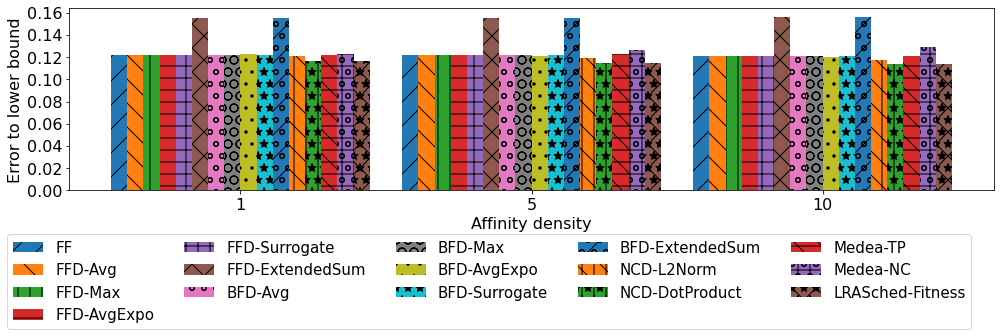

In [60]:
#for c in classes: 
c = "arbitrary"
fig = plot_barchart(twodim_eps, c, df_2d_column_names, "Affinity density", 'Error to lower bound')
filename = f"{proj_path}/plots/density2D_result_{c}.pdf" 
fig.savefig(filename)

In [ ]:
#for c in classes: 
#    plot_density_barchart(twodim_time, c, df_2d_column_names, 'Time consumption (s)')

If removing the time consumption of NodeCount:

In [13]:
time_cols_without_nodecount = df_2d_column_names.copy()
time_cols_without_nodecount.remove("NodeCount")

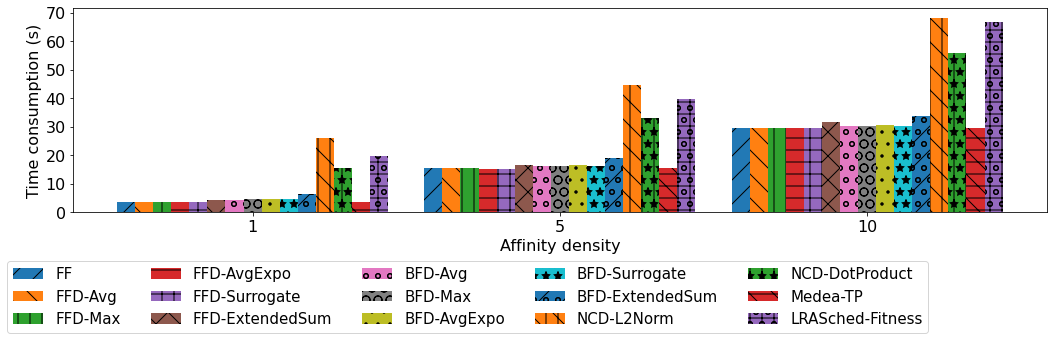

In [61]:
#for c in classes: 
c = "arbitrary"
fig = plot_barchart(twodim_time, c, time_cols_without_nodecount, "Affinity density", 'Time consumption (s)')

filename = f"{proj_path}/plots/density2D_time_{c}.pdf"
fig.savefig(filename)

## 1.2 Impact of LRA Submission Scale on Effectiveness and Time Consumption 

In [15]:
df_large = pd.read_csv(file_large, sep='\t') ## df_2d_large

twodim_eps_scale, twodim_time_scale = get_scale_exp_results(df_large, df_2d_large_column_names)
twodim_eps_scale.columns = ['class', 'density'] + df_2d_large_column_names
twodim_time_scale.columns = ['class', 'density'] + df_2d_large_column_names

In [16]:
twodim_eps_scale[twodim_eps['class'] == 'arbitrary'].sort_values(by='density')

,class,density,FF,FFD-Avg,FFD-Max,FFD-AvgExpo,FFD-Surrogate,FFD-ExtendedSum,BFD-Avg,BFD-Max,BFD-AvgExpo,BFD-Surrogate,BFD-ExtendedSum,BCD-DotProduct,FFD-Degree,BCD-Fitness
0,arbitrary,10000,0.0270,0.0270,0.0270,0.0270,0.0270,0.0339,0.0270,0.0270,0.0270,0.0270,0.0339,0.0260,0.0274,0.0260
1,arbitrary,50000,0.0243,0.0243,0.0243,0.0243,0.0243,0.0381,0.0243,0.0243,0.0244,0.0243,0.0381,0.0234,0.0241,0.0234
2,arbitrary,100000,0.0240,0.0240,0.0240,0.0240,0.0240,0.0378,0.0240,0.0240,0.0241,0.0240,0.0378,0.0232,0.0240,0.0232


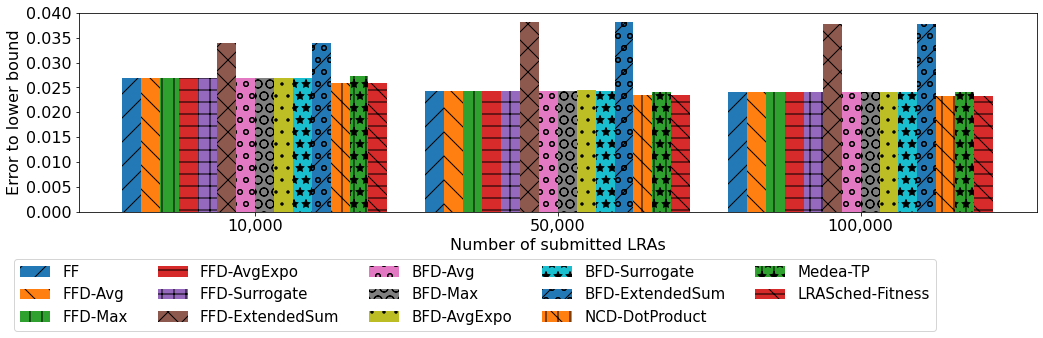

In [62]:
#for c in classes: 
c = "arbitrary"
fig = plot_barchart(twodim_eps_scale, c, df_2d_large_column_names, "Number of submitted LRAs",
                    'Error to lower bound')    
filename = f"{proj_path}/plots/large2D_result_{c}.pdf" 
fig.savefig(filename)

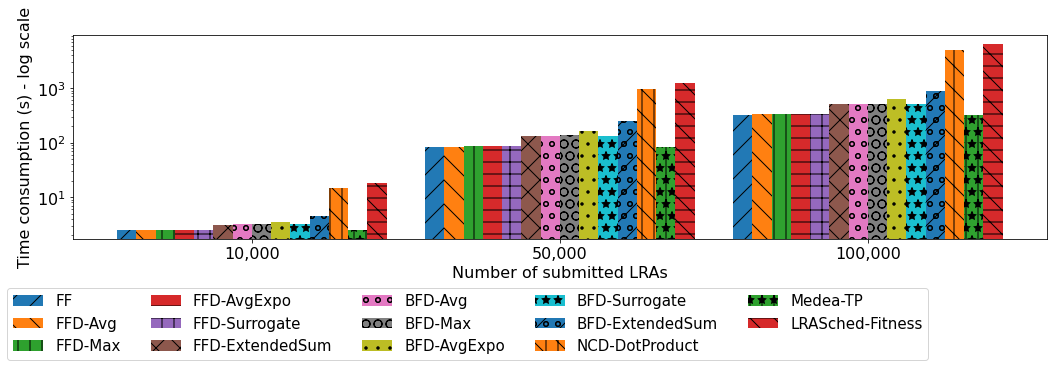

In [63]:
#for c in classes: 
c = "arbitrary"
#fig = plot_scale_barchart(twodim_time_scale, c, df_2d_large_column_names, 'Time consumption (s)')
fig = plot_barchart(twodim_time_scale, c, df_2d_large_column_names, "Number of submitted LRAs",
                    'Time consumption (s) - log scale', True)

filename = f"{proj_path}/plots/large2D_time_{c}.pdf" 
fig.savefig(filename)

# Result-2: Time-Varying Res Request

In [41]:
df_ts = pd.read_csv(file_ts, sep='\t')
ts_eps, ts_time = get_exp_results(df_ts, df_ts_large_column_names)
ts_eps.columns = ['class', 'density'] + df_ts_large_column_names
ts_time.columns = ['class', 'density'] + df_ts_large_column_names

## 2.1 Impact of Affinity Density On Effectiveness and Time Consumption

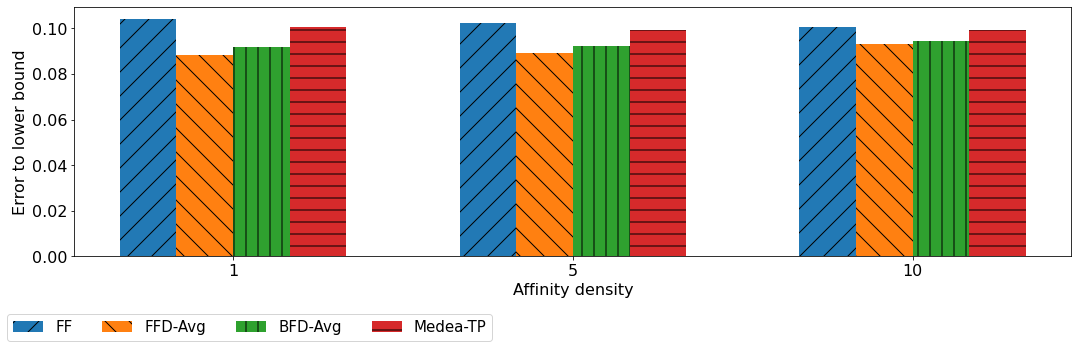

In [64]:
#for c in classes: 
c = "arbitrary"
fig = plot_barchart(ts_eps, c, df_ts_large_column_names, "Affinity density", 'Error to lower bound')

filename = f"{proj_path}/plots/densityTS_result_{c}.pdf" 
fig.savefig(filename)

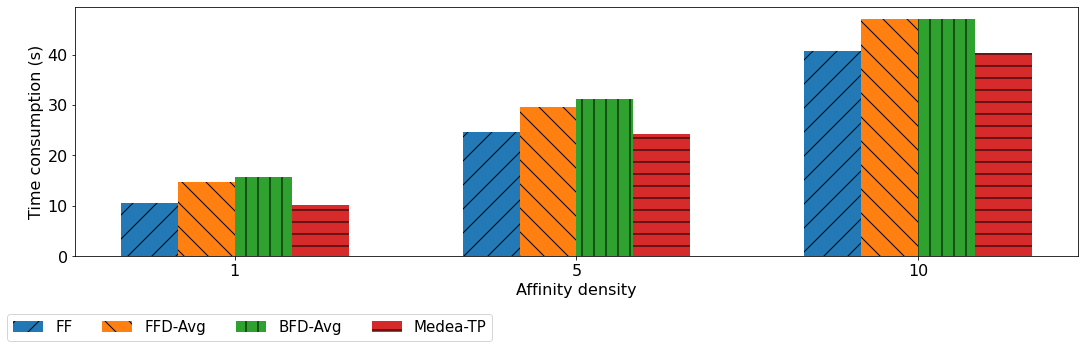

In [65]:
#for c in classes: 
c = "arbitrary"
fig = plot_barchart(ts_time, c, df_ts_large_column_names, "Affinity density", 'Time consumption (s)')

filename = f"{proj_path}/plots/densityTS_time_{c}.pdf" 
fig.savefig(filename)

## 2.2 Impact of LRA Submission Scale On Effectiveness and Time Consumption

In [22]:
df_large_ts = pd.read_csv(file_largeTS, sep='\t') ## df_TS_large

ts_eps_scale, ts_time_scale = get_scale_exp_results(df_large_ts, df_ts_large_column_names)
ts_eps_scale.columns = ['class', 'density'] + df_ts_large_column_names
ts_time_scale.columns = ['class', 'density'] + df_ts_large_column_names

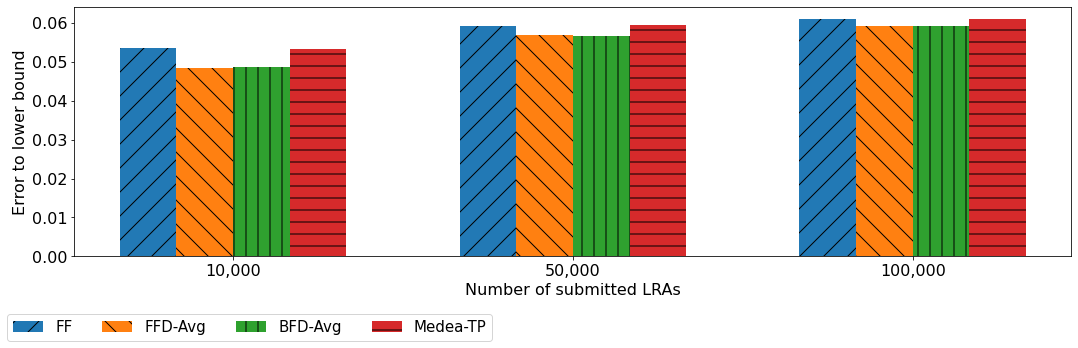

In [66]:
#for c in classes: 
c = "arbitrary"
fig = plot_barchart(ts_eps_scale, c, df_ts_large_column_names, "Number of submitted LRAs", 'Error to lower bound')    
filename = f"{proj_path}/plots/largeTS_result_{c}.pdf" 
fig.savefig(filename)

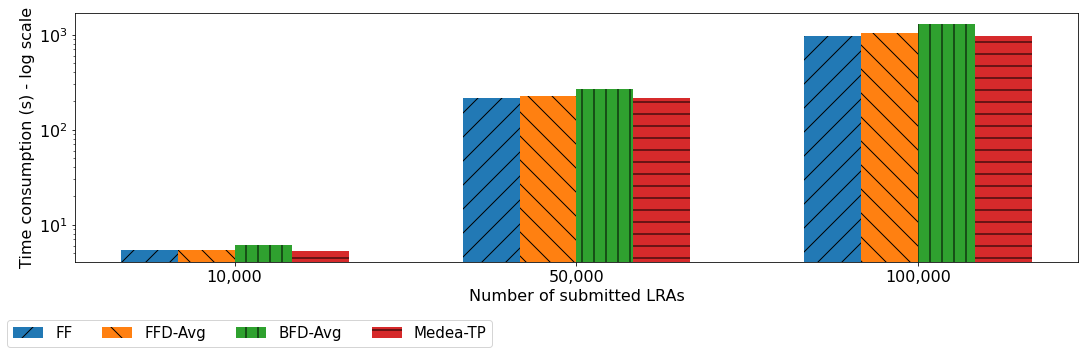

In [67]:
#for c in classes: 
c = "arbitrary"
fig = plot_barchart(ts_time_scale, c, df_ts_large_column_names, "Number of submitted LRAs",
                    'Time consumption (s) - log scale', True)

filename = f"{proj_path}/plots/largeTS_time_{c}.pdf" 
fig.savefig(filename)

# Result-3: Scalability with Varying Res Request

In [44]:
def get_scalability_exp_results(sub_df, alg_column_names):
    sub_df['class'] = sub_df['instance_name'].apply(lambda x: x.split('_')[2])
    sub_df['LRAnum'] = sub_df['instance_name'].apply(lambda x: int(x.split('_')[1]))
    
    for i in alg_column_names:
        sub_df[i + '_eps'] = round(sub_df[i]/sub_df['LB'] - 1, 3)
        sub_df[i + '_time'] = sub_df[i + '_time'].apply(lambda x: round(x, 4))

    epsilon_column_names = [i + '_eps' for i in alg_column_names]
    time_column_names = [i + '_time' for i in alg_column_names]
    df_eps = sub_df[['class', 'LRAnum'] + epsilon_column_names]
    df_time = sub_df[['class', 'LRAnum'] + time_column_names]
    return df_eps, df_time

In [45]:
df_scalab = pd.read_csv(file_scalabilityTS, sep='\t')
scalab_eps, scalab_time = get_scalability_exp_results(df_scalab, df_scalab_column_names)
scalab_eps.columns = ['class', 'density'] + df_scalab_column_names
scalab_time.columns = ['class', 'density'] + df_scalab_column_names

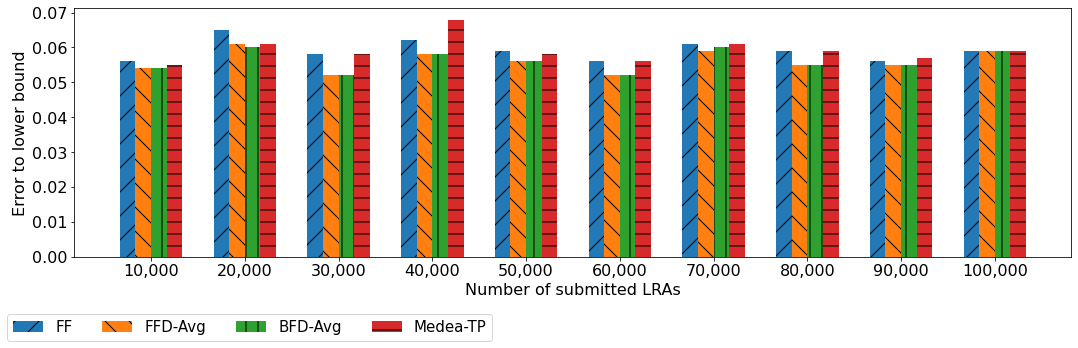

In [68]:
#for c in classes: 
c = "arbitrary"
fig = plot_barchart(scalab_eps, c, df_scalab_column_names, "Number of submitted LRAs", 'Error to lower bound')    
filename = f"{proj_path}/plots/scalabilityTS_result_{c}.pdf" 
fig.savefig(filename)

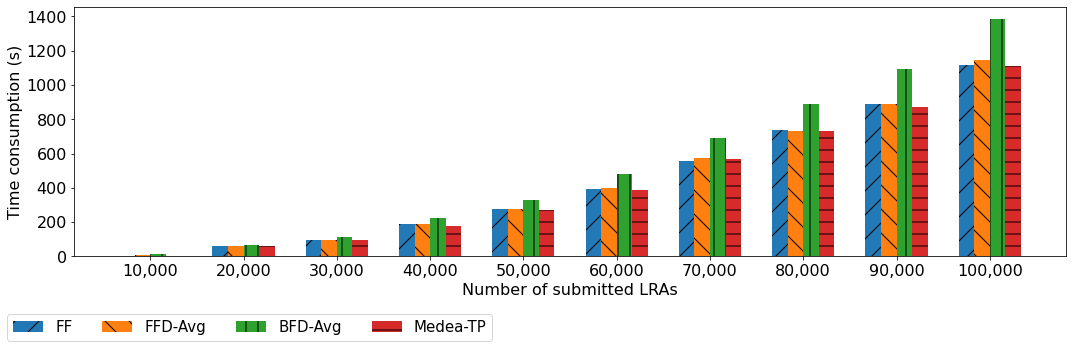

In [69]:
#for c in classes: 
c = "arbitrary"
fig = plot_barchart(scalab_time, c, df_scalab_column_names, "Number of submitted LRAs", 'Time consumption (s)')

filename = f"{proj_path}/plots/scalabilityTS_time_{c}.pdf" 
fig.savefig(filename)

# Result-4: Scheduling per Batch with Varying Res Request

In [48]:
df_batch = pd.read_csv(file_batchTS, sep='\t')
batch_eps, batch_time = get_exp_results(df_batch, df_batch_column_names)
batch_eps.columns = ['class', 'density'] + df_batch_column_names
batch_time.columns = ['class', 'density'] + df_batch_column_names

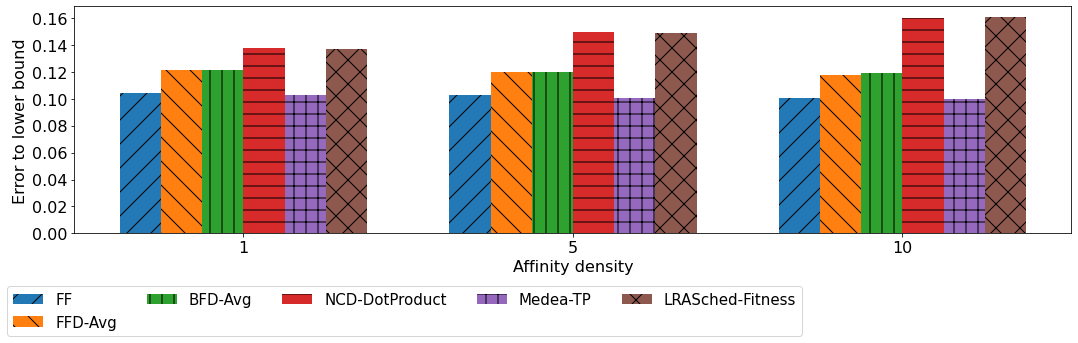

In [70]:
#for c in classes: 
c = "arbitrary"
fig = plot_barchart(batch_eps, c, df_batch_column_names, "Affinity density", 'Error to lower bound')

filename = f"{proj_path}/plots/batchTS_result_{c}.pdf" 
fig.savefig(filename)

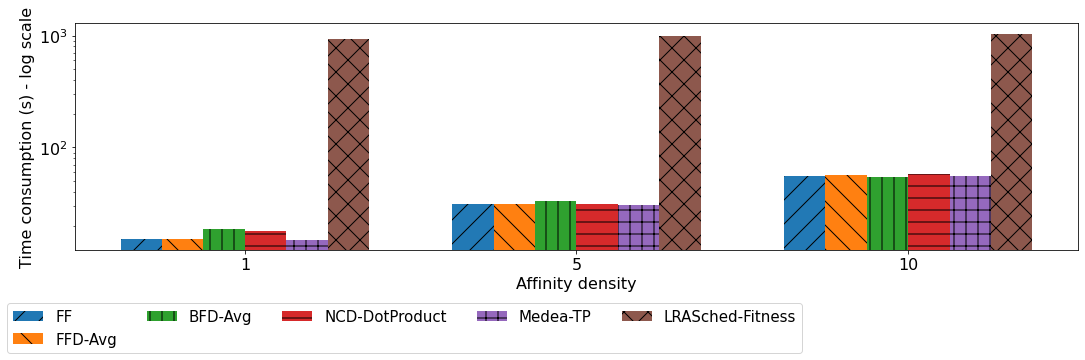

In [71]:
#for c in classes: 
c = "arbitrary"
fig = plot_barchart(batch_time, c, df_batch_column_names, "Affinity density",
                    'Time consumption (s) - log scale', True)

filename = f"{proj_path}/plots/batchTS_time_{c}.pdf" 
fig.savefig(filename)